### Feature engineering for model development

In [1]:
import pandas as pd

# Load the dataset
file_path = 'synthetic_rainfall_data.xlsx'
data = pd.read_excel(file_path)

# Ensure Date column is in datetime format and sort by date
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data.dropna(subset=['Date'], inplace=True)
data.sort_values(by='Date', inplace=True)

# Extract month and year from the Date column
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year

# Map month numbers to month names
month_name_mapping = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 
    6: 'June', 7: 'July', 8: 'August', 9: 'September', 
    10: 'October', 11: 'November', 12: 'December'
}
data['Month_Name'] = data['Month'].map(month_name_mapping)

# Check if all months are present
print("Unique months in the dataset:", data['Month_Name'].unique())

# Create dummy variables for months (even if a month is missing, we ensure all months are accounted for)
all_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
data['Month_Name'] = pd.Categorical(data['Month_Name'], categories=all_months, ordered=True)
month_dummies = pd.get_dummies(data['Month_Name'], prefix='Month', drop_first=True)

# Create dummy variables for years
year_dummies = pd.get_dummies(data['Year'], prefix='Year')

# Concatenate the dummy variables with the original dataset
data_with_dummies = pd.concat([data, month_dummies, year_dummies], axis=1)

# Drop the original Month, Month_Name, and Year columns if no longer needed
data_with_dummies.drop(['Month', 'Month_Name', 'Year'], axis=1, inplace=True)

# Save the updated dataset to an Excel file
output_file_path = 'synthetic_rainfall_data_add.xlsx'
data_with_dummies.to_excel(output_file_path, index=False)

print(f"Updated dataset saved as {output_file_path}")

Unique months in the dataset: ['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August'
 'September' 'October' 'November' 'December']
Updated dataset saved as synthetic_rainfall_data_add.xlsx


/var/folders/2p/1ht8mnjx2lzg18jq44hl6p7r0000gn/T/ipykernel_2716/2952578218.py:8: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['Date'] = pd.to_datetime(data['Date'], errors='coerce')


### Random Forests with TimeSeriesCV for predictive analysis

Best Random Forest Model: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Optimized Random Forest Model - Mean Absolute Error: 3.006072288772477
Optimized Random Forest Model - Mean Squared Error: 16.05627189967866
Optimized Random Forest Model - Root Mean Squared Error: 4.007027813689176
Optimized Random Forest Model - Adjusted R-squared: 0.7074701011902207


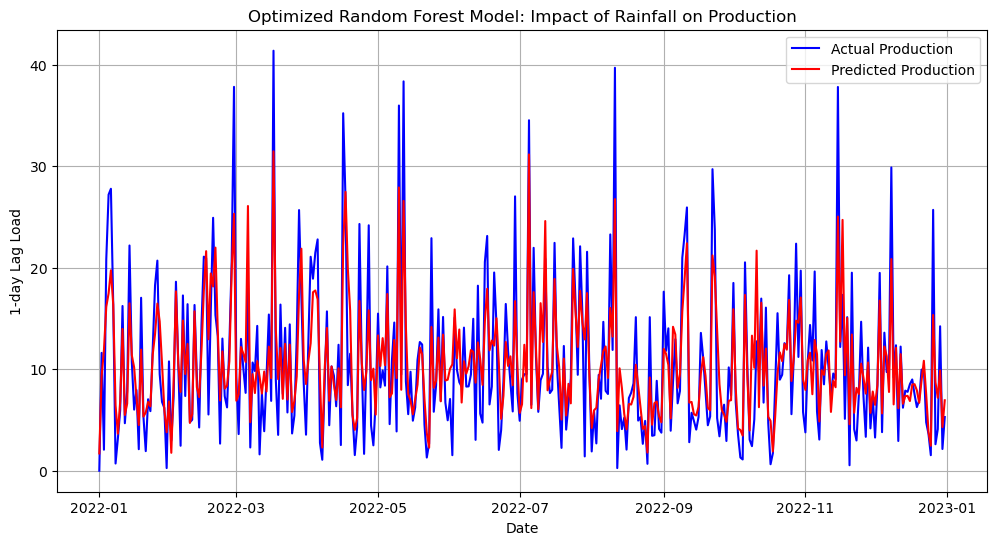

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load the updated dataset
file_path = 'synthetic_rainfall_data_add.xlsx'
data = pd.read_excel(file_path)

# Set 'Date' as index and sort by 'Date'
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.sort_index(inplace=True)

# Define the target variable and features
y = data['1_day Lag Load']
X = data[['daily_rain', 'Cumulative_rainfall_3_days', 
          'Month_February', 'Month_March', 'Month_April', 
          'Month_May', 'Month_June', 'Month_July', 'Month_August', 
          'Month_September', 'Month_October', 'Month_November', 'Month_December', 
          'Year_2022']]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Define the Random Forest model and hyperparameter grid
model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Grid Search with TimeSeriesSplit
grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='r2', n_jobs=-1)
grid_search.fit(X_scaled, y)

# Best model and parameters
best_model = grid_search.best_estimator_
print(f"Best Random Forest Model: {grid_search.best_params_}")

# Forecasting with the best model
y_pred = best_model.predict(X_scaled)

# Evaluate the model
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)
n = X_scaled.shape[0]
p = X_scaled.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"Optimized Random Forest Model - Mean Absolute Error: {mae}")
print(f"Optimized Random Forest Model - Mean Squared Error: {mse}")
print(f"Optimized Random Forest Model - Root Mean Squared Error: {rmse}")
print(f"Optimized Random Forest Model - Adjusted R-squared: {adjusted_r2}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(data.index, y, label='Actual Production', color='blue')
plt.plot(data.index, y_pred, label='Predicted Production', color='red')
plt.xlabel('Date')
plt.ylabel('1-day Lag Load')
plt.title('Optimized Random Forest Model: Impact of Rainfall on Production')
plt.legend()
plt.grid(True)
plt.show()

### Threshold Analysis

Best Random Forest Model: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}

The 3-day cumulative rainfall amount where production is expected to drop below 6650 tonnes is approximately 0.00 mm.
The largest production drop occurs at 57.01 mm, with a drop of -4.48 tonnes (-20.21%).


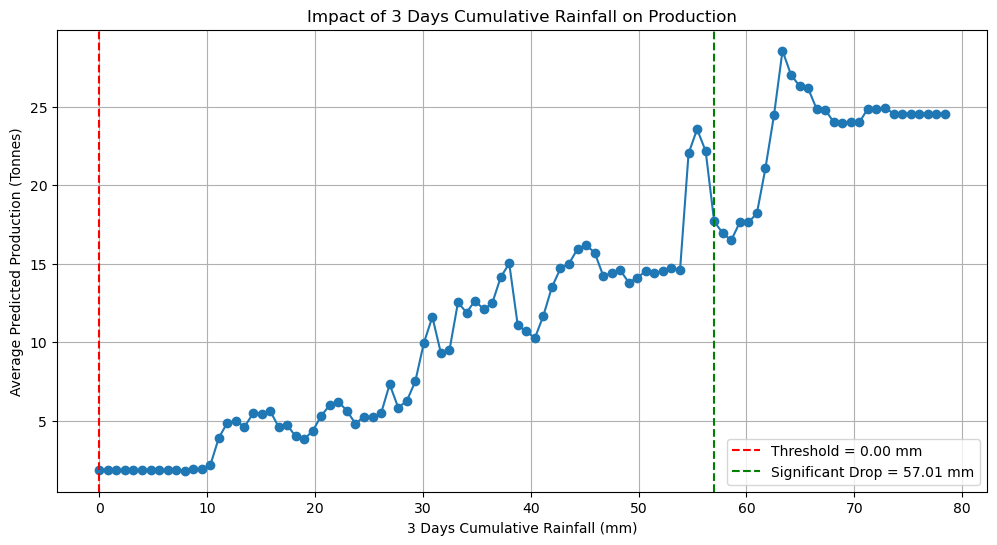

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the updated dataset
file_path = 'synthetic_rainfall_data_add.xlsx'
data = pd.read_excel(file_path)

# Set 'Date' as index and sort by 'Date'
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.sort_index(inplace=True)

# Define the target variable and features
y = data['1_day Lag Load']
X = data[['daily_rain', 'Cumulative_rainfall_3_days', 
          'Month_February', 'Month_March', 'Month_April', 
          'Month_May', 'Month_June', 'Month_July', 'Month_August', 
          'Month_September', 'Month_October', 'Month_November', 'Month_December', 
          'Year_2022']]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Define the Random Forest model and hyperparameter grid
model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Grid Search with TimeSeriesSplit
grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='r2', n_jobs=-1)
grid_search.fit(X_scaled, y)

# Best model and parameters
best_model = grid_search.best_estimator_
print(f"Best Random Forest Model: {grid_search.best_params_}\n")

# Define the range of cumulative rainfall values
rainfall_values = np.linspace(data['Cumulative_rainfall_3_days'].min(), 
                              data['Cumulative_rainfall_3_days'].max(), 100)

# To store results
impact_results = []

# Convert X back to DataFrame for easier column manipulation
X_df = pd.DataFrame(X_scaled, columns=['daily_rain', 
                                       'Cumulative_rainfall_3_days', 
                                       'Month_February', 'Month_March', 'Month_April', 
                                       'Month_May', 'Month_June', 'Month_July', 'Month_August', 
                                       'Month_September', 'Month_October', 'Month_November', 'Month_December', 
                                       'Year_2022'])

# Iterate over the rainfall values and calculate the corresponding production
for value in rainfall_values:
    X_copy = X_df.copy()
    X_copy['Cumulative_rainfall_3_days'] = value 
    
    # Impute missing values
    X_copy_imputed = imputer.transform(X_copy)
    
    # Scale features
    X_copy_scaled = scaler.transform(X_copy_imputed)
    
    # Predict using the model
    y_pred = best_model.predict(X_copy_scaled)
    
    # Calculate the average production
    average_production = np.mean(y_pred)
    
    impact_results.append((value, average_production))

# Convert impact results to DataFrame
impact_df = pd.DataFrame(impact_results, columns=['Cumulative_Rainfall_3_days', 'Average_Production'])

# Find the rainfall where production drops below the threshold
threshold = 6650
below_threshold = impact_df[impact_df['Average_Production'] <= threshold]
if not below_threshold.empty:
    threshold_rainfall = below_threshold['Cumulative_Rainfall_3_days'].iloc[0]
else:
    threshold_rainfall = np.nan

# Calculate the largest absolute drop in production (consecutive rainfall values)
impact_df['Production_Difference'] = impact_df['Average_Production'].diff()  
significant_drop = impact_df['Production_Difference'].idxmin() 
significant_drop_rainfall = impact_df['Cumulative_Rainfall_3_days'].iloc[significant_drop]
significant_drop_amount = impact_df['Production_Difference'].iloc[significant_drop]

# Calculate the percentage drop at this point
significant_drop_percentage = (significant_drop_amount / impact_df['Average_Production'].iloc[significant_drop - 1]) * 100

# Print out the impact analysis
print(f"The 3-day cumulative rainfall amount where production is expected to drop below {threshold} tonnes is approximately {threshold_rainfall:.2f} mm.")
print(f"The largest production drop occurs at {significant_drop_rainfall:.2f} mm, with a drop of {significant_drop_amount:.2f} tonnes ({significant_drop_percentage:.2f}%).")

# Plot the impact with the threshold and significant drop highlighted
plt.figure(figsize=(12, 6))
plt.plot(impact_df['Cumulative_Rainfall_3_days'], impact_df['Average_Production'], marker='o', linestyle='-')
if not np.isnan(threshold_rainfall):
    plt.axvline(x=threshold_rainfall, color='r', linestyle='--', label=f'Threshold = {threshold_rainfall:.2f} mm')
plt.axvline(x=significant_drop_rainfall, color='g', linestyle='--', label=f'Significant Drop = {significant_drop_rainfall:.2f} mm')

plt.xlabel('3 Days Cumulative Rainfall (mm)')
plt.ylabel('Average Predicted Production (Tonnes)')
plt.title('Impact of 3 Days Cumulative Rainfall on Production')
plt.legend()
plt.grid(True)
plt.show()